In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Set your folder path
import os
import pandas as pd

folder_path = "/content/drive/MyDrive/PHQ8_Project/all_speakers"

# Step 3: Define required columns
required_columns = {"Transcript", "Speaker"}

# Step 4: Initialize results
corrupt_files = []
valid_files = []

# Step 5: Check each file
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        try:
            df = pd.read_csv(file_path)

            # Check if file is truly empty
            if df.empty:
                corrupt_files.append((filename, "Empty file"))
                continue

            # Check if required columns exist
            if not required_columns.issubset(set(df.columns)):
                missing = required_columns - set(df.columns)
                corrupt_files.append((filename, f"Missing columns: {missing}"))
                continue

            # Check if Transcript column is effectively blank
            if df['Transcript'].dropna().apply(lambda x: str(x).strip()).eq("").all():
                corrupt_files.append((filename, "Transcript column is empty or blank"))
                continue

            # Passed all checks
            valid_files.append(filename)

        except Exception as e:
            corrupt_files.append((filename, f"Read error: {str(e)}"))

print("\n❌ Corrupt or Problematic CSV Files:")
for f, reason in corrupt_files:
    print(f"  - {f}: {reason}")


Mounted at /content/drive

❌ Corrupt or Problematic CSV Files:


In [ ]:
required_columns = {"Transcript", "Speaker"}

def is_placeholder(text):
    stripped = str(text).strip().lower()
    return stripped in ["", "''", '""', "...", ".", "..", "na", "nan", " "]

# Step 4: Loop through and evaluate each file
valid_files = []
corrupt_files = []

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        try:
            df = pd.read_csv(file_path)

            # Check 1: Completely empty
            if df.empty:
                corrupt_files.append((filename, "Empty file"))
                continue

            # Check 2: Missing required columns
            if not required_columns.issubset(df.columns):
                missing = required_columns - set(df.columns)
                corrupt_files.append((filename, f"Missing columns: {missing}"))
                continue

            # Check 3: Transcript is all blank/placeholder
            if df['Transcript'].dropna().apply(is_placeholder).all():
                corrupt_files.append((filename, "Transcript column is blank or only placeholders"))
                continue

            # Valid if all checks passed
            valid_files.append(filename)

        except Exception as e:
            corrupt_files.append((filename, f"Read error: {str(e)}"))

print("\n❌ CORRUPT OR BROKEN FILES:")
for f, reason in corrupt_files:
    print(f"  - {f}: {reason}")


❌ CORRUPT OR BROKEN FILES:
  - 638_transcript.csv: Transcript column is blank or only placeholders
  - 692_transcript.csv: Transcript column is blank or only placeholders
  - 601_transcript.csv: Transcript column is blank or only placeholders


In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Set folder path
import os
import pandas as pd

folder_path = "/content/drive/MyDrive/PHQ8_Project/all_speakers"  # <-- change if needed

Mounted at /content/drive


In [ ]:
# STEP 3: Define logic to detect interviewer

def detect_roles(df):
    if "Transcript" not in df.columns or "Speaker" not in df.columns:
        return df  # Return unchanged if structure is broken

    df['Transcript'] = df['Transcript'].fillna("").astype(str)

    # Step 1: Check for 'Ellie' mentions
    ellie_speaker = None
    for speaker in df["Speaker"].unique():
        speaker_lines = df[df["Speaker"] == speaker]["Transcript"]
        if speaker_lines.str.contains("ellie", case=False).any():
            ellie_speaker = speaker
            break

    # Step 2: If no "Ellie" found, compare number of questions
    if not ellie_speaker:
        question_counts = df.groupby("Speaker")["Transcript"].apply(lambda x: x.str.count(r"\?").sum())
        if question_counts.nunique() == 1:
            # Step 3: Tie-breaker using average word count
            avg_word_counts = df.groupby("Speaker")["Transcript"].apply(lambda x: x.apply(lambda s: len(str(s).split())).mean())
            ellie_speaker = avg_word_counts.idxmin()  # Shorter speaker = interviewer
        else:
            ellie_speaker = question_counts.idxmax()

    # Final Role Assignment
    df["role"] = df["Speaker"].apply(lambda x: "interviewer" if x == ellie_speaker else "interviewee")
    return df


In [ ]:
# STEP 3: Define role classification logic
def detect_roles(df):
    if "Transcript" not in df.columns or "Speaker" not in df.columns:
        return df  # Skip if structure is bad

    df['Transcript'] = df['Transcript'].fillna("").astype(str)

    # Step 1: Ellie mention
    ellie_speaker = None
    for speaker in df["Speaker"].unique():
        lines = df[df["Speaker"] == speaker]["Transcript"]
        if lines.str.contains("ellie", case=False).any():
            ellie_speaker = speaker
            break

    # Step 2: Question count
    if not ellie_speaker:
        question_counts = df.groupby("Speaker")["Transcript"].apply(lambda x: x.str.count(r"\?").sum())
        if question_counts.nunique() == 1:
            # Step 3: Tie-breaker — average words per turn
            avg_word_counts = df.groupby("Speaker")["Transcript"].apply(lambda x: x.apply(lambda s: len(str(s).split())).mean())
            ellie_speaker = avg_word_counts.idxmin()
        else:
            ellie_speaker = question_counts.idxmax()

    # Assign roles
    df["role"] = df["Speaker"].apply(lambda x: "interviewer" if x == ellie_speaker else "interviewee")
    return df


In [ ]:
# STEP 4: Loop through and OVERWRITE each file with new role column
updated = 0
skipped = 0

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        try:
            df = pd.read_csv(file_path)
            df = detect_roles(df)
            df.to_csv(file_path, index=False)  # OVERWRITE the file
            updated += 1
        except Exception as e:
            print(f"❌ Failed on {filename}: {e}")
            skipped += 1

print(f"\n✅ Completed: {updated} files updated with role column.")
if skipped:
    print(f"⚠️ Skipped {skipped} files due to errors.")



✅ Completed: 275 files updated with role column.


#Transformer on clinical data to get the positive and negative sentiments

In [ ]:
!pip install transformers

from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cuda:0


In [ ]:
import os
import re
import pandas as pd
from transformers import pipeline

We calculate:

sentiment_score
=
𝑃
(
POSITIVE
)
−
𝑃
(
NEGATIVE
)
sentiment_score=P(POSITIVE)−P(NEGATIVE)
This gives you a balanced continuous score:

Close to +1 → clearly positive

Close to –1 → clearly negative

Close to 0 → neutral or ambiguous

In [ ]:
# 📂 STEP 3: Set your folder path (update this path)
folder_path = "/content/drive/MyDrive/PHQ8_Project/all_speakers"  # for Google Drive
# folder_path = "path/to/your/local/folder"  # if running locally

# 🧠 STEP 4: Load the sentiment model (returns both POS/NEG probabilities)
classifier = pipeline("sentiment-analysis", return_all_scores=True)

# 🧮 STEP 5: Define a scoring function
def compute_intensity(text: str) -> float:
    """Returns sentiment intensity = P(positive) - P(negative)"""
    scores = classifier(text)[0]
    pos = next(x["score"] for x in scores if x["label"] == "POSITIVE")
    neg = next(x["score"] for x in scores if x["label"] == "NEGATIVE")
    return pos - neg  # range: [-1, +1]

# 📊 STEP 6: Loop through each file and analyze
summary = []

for filename in sorted(os.listdir(folder_path)):
    if not filename.endswith(".csv"):
        continue

    file_path = os.path.join(folder_path, filename)
    try:
        df = pd.read_csv(file_path)

        # Check if required columns are present
        if not all(col in df.columns for col in ["role", "Transcript"]):
            continue

        # Filter to interviewee lines
        iv_lines = df[df["role"] == "interviewee"]["Transcript"].dropna().astype(str)
        if iv_lines.empty:
            continue

        # Compute intensity for each line
        intensities = [compute_intensity(line) for line in iv_lines]
        avg_intensity = sum(intensities) / len(intensities)

        # Label based on average intensity
        label = "positive" if avg_intensity > 0 else "negative" if avg_intensity < 0 else "neutral"

        # Extract numeric participant ID
        match = re.findall(r"\d+", filename)
        participant_id = int(match[0]) if match else filename

        summary.append({
            "participant_id": participant_id,
            "aggregate_intensity": round(avg_intensity, 4),
            "emotion_label": label
        })

    except Exception as e:
        print(f"⚠️ Error in file {filename}: {e}")

# 📁 STEP 7: Save results to CSV
summary_df = pd.DataFrame(summary).sort_values("participant_id").reset_index(drop=True)
output_path = os.path.join(folder_path, "interviewee_sentiment_summary.csv")
summary_df.to_csv(output_path, index=False)

print(f"✅ Summary saved for {len(summary_df)} participants to:\n{output_path}")
summary_df.head()

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


✅ Summary saved for 275 participants to:
/content/drive/MyDrive/PHQ8_Project/all_speakers/interviewee_sentiment_summary.csv


,participant_id,aggregate_intensity,emotion_label
0,300,0.0,neutral
1,301,0.0,neutral
2,302,0.0,neutral
3,303,0.0,neutral
4,304,0.0,neutral


# Ranksum test or T-test of aggregate emotions with participants label

---



In [ ]:
# Step 1: Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import anderson, ttest_ind, mannwhitneyu


In [ ]:
# Step 2: Load CSVs (upload first in Colab)
sentiment_df = pd.read_csv("interviewee_sentiment_summary.csv")
ground_truth_df = pd.read_csv("GroundTruth Table.csv")

# Merge on participant ID
df = pd.merge(sentiment_df, ground_truth_df, left_on="participant_id", right_on="Participant_ID")


In [ ]:
# Step 3: List of binary label columns
label_columns = ['PTSD_Label', 'Depression_Label', 'Appetite_Label',
                 'Agency_Label', 'Anxiety_Label', 'Sleep_Label']


In [ ]:
# Step 4: Analyze each label
results = []

for label in label_columns:
    # Split sentiment scores based on label
    group0 = df[df[label] == 0]['aggregate_sentiment_score']
    group1 = df[df[label] == 1]['aggregate_sentiment_score']

    # Class balance
    size_0, size_1 = len(group0), len(group1)
    imbalance_ratio = min(size_0, size_1) / (size_0 + size_1)

    # Normality test for sentiment scores in each group
    ad_0 = anderson(group0, dist='norm')
    ad_1 = anderson(group1, dist='norm')
    normal_0 = ad_0.statistic < ad_0.critical_values[2]
    normal_1 = ad_1.statistic < ad_1.critical_values[2]

    # Choose test based on normality
    if normal_0 and normal_1:
        test_used = "Welch's t-test"
        stat, pval = ttest_ind(group0, group1, equal_var=False)
    else:
        test_used = "Mann–Whitney U test"
        stat, pval = mannwhitneyu(group0, group1, alternative='two-sided')

    # Interpretation
    if pval < 0.05:
        direction = "higher" if group1.mean() > group0.mean() else "lower"
        interpretation = f"Group 1 has significantly {direction} sentiment than Group 0."
    else:
        interpretation = "No significant difference."

    results.append({
        "Label": label,
        "Group 0 Size": size_0,
        "Group 1 Size": size_1,
        "Class Imbalance?": imbalance_ratio < 0.4,
        "Normal Group 0": normal_0,
        "Normal Group 1": normal_1,
        "Test Used": test_used,
        "Group 0 Mean": round(group0.mean(), 4),
        "Group 1 Mean": round(group1.mean(), 4),
        "P-Value": round(pval, 5),
        "Significant?": pval < 0.05,
        "Interpretation": interpretation
    })


In [ ]:
# Step 5: Display the results
results_df = pd.DataFrame(results)
display(results_df)


,Label,Group 0 Size,Group 1 Size,Class Imbalance?,Normal Group 0,Normal Group 1,Test Used,Group 0 Mean,Group 1 Mean,P-Value,Significant?,Interpretation
0,PTSD_Label,188,88,True,True,False,Mann–Whitney U test,0.0886,0.0040,0.00267,True,Group 1 has significantly lower sentiment than...
1,Depression_Label,210,66,True,True,False,Mann–Whitney U test,0.0792,0.0057,0.01000,True,Group 1 has significantly lower sentiment than...
2,Appetite_Label,199,77,True,True,False,Mann–Whitney U test,0.0742,0.0289,0.05388,False,No significant difference.
3,Agency_Label,137,139,False,False,True,Mann–Whitney U test,0.0020,0.1203,0.00001,True,Group 1 has significantly higher sentiment tha...
4,Anxiety_Label,127,149,False,True,True,Welch's t-test,0.1167,0.0146,0.00028,True,Group 1 has significantly lower sentiment than...
5,Sleep_Label,176,100,True,True,True,Welch's t-test,0.0759,0.0364,0.18195,False,No significant difference.


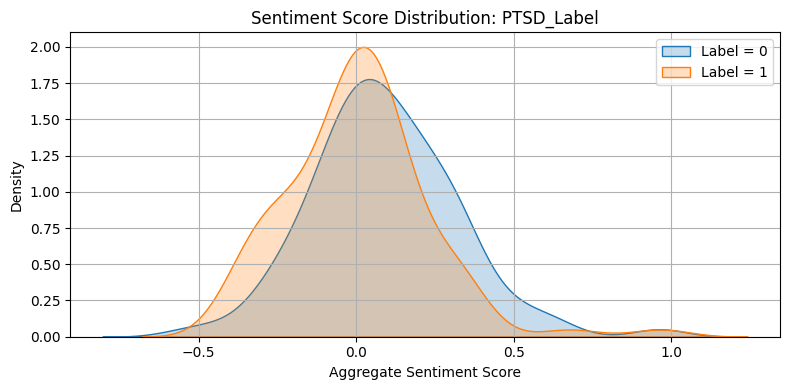

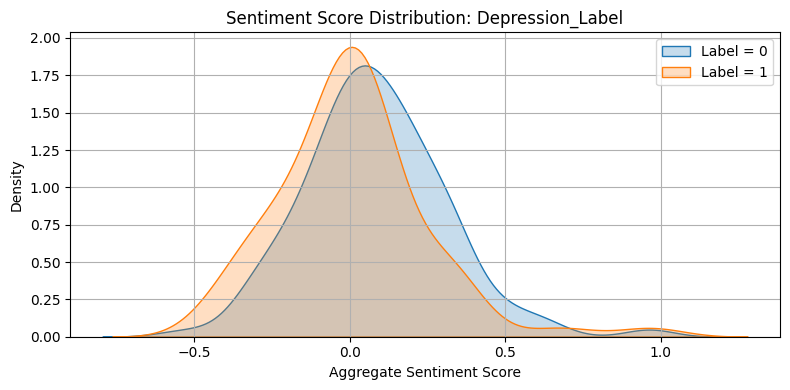

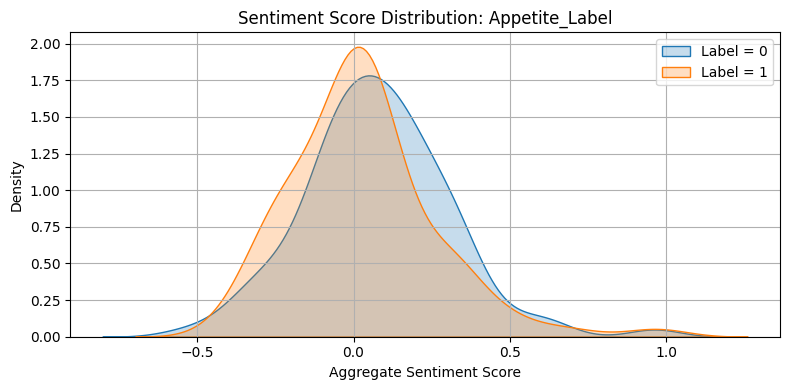

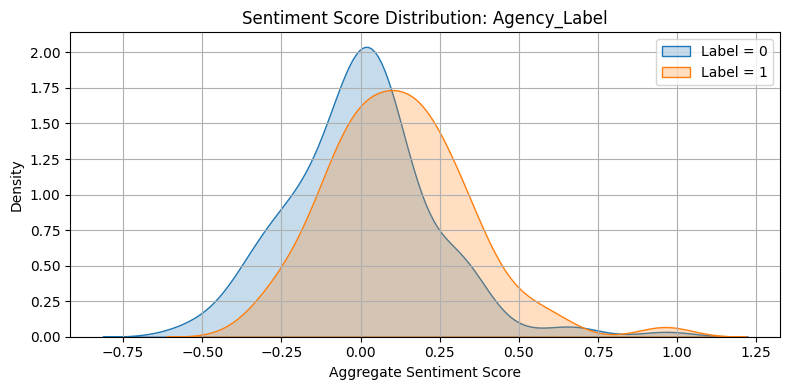

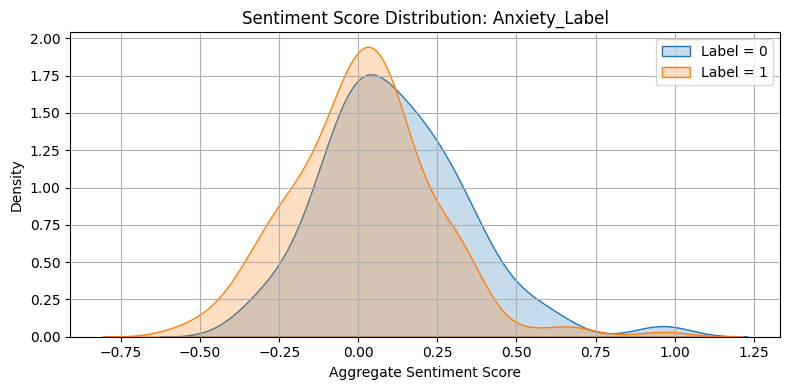

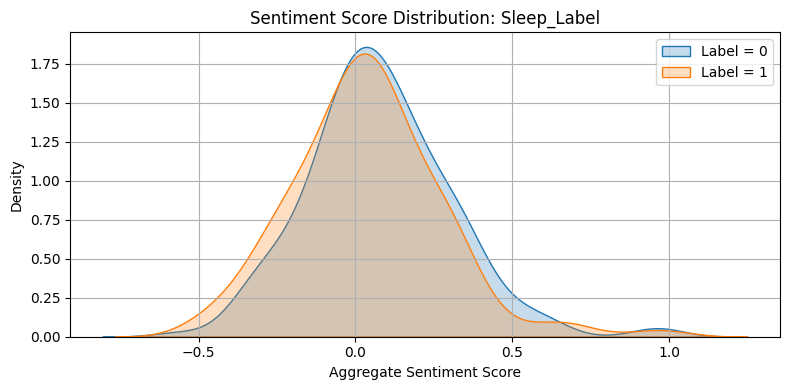

In [ ]:
# Step 6: Plot sentiment distributions by label
for label in label_columns:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(df[df[label] == 0]['aggregate_sentiment_score'], label='Label = 0', fill=True)
    sns.kdeplot(df[df[label] == 1]['aggregate_sentiment_score'], label='Label = 1', fill=True)
    plt.title(f"Sentiment Score Distribution: {label}")
    plt.xlabel("Aggregate Sentiment Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
